In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('/content/modified_ais_data.csv',nrows=1000)

In [3]:
df.head()

,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG
0,2022-03-31T00:00:01,671226100,IMO9221322,25.77626,-80.20320,3.2,143.7
1,2022-03-31T00:00:06,367452810,IMO9602344,29.32824,-94.77391,2.6,319.2
2,2022-03-31T00:00:09,366919770,IMO9253583,48.74428,-122.49504,0.0,210.3
3,2022-03-31T00:00:00,311000966,IMO8916607,18.55833,-66.47910,17.5,274.5
4,2022-03-31T00:00:01,219028420,IMO9411305,28.66703,-93.59339,9.5,129.4


In [4]:
import math

def lat_lon_to_cartesian(lat, lon, R=6371):
    lat_rad = math.radians(lat)
    lon_rad = math.radians(lon)
    x = R * math.cos(lat_rad) * math.cos(lon_rad)
    y = R * math.cos(lat_rad) * math.sin(lon_rad)
    z = R * math.sin(lat_rad)
    return x, y, z

def cartesian_to_lat_lon(x, y, z, R=6371):
    lon = math.degrees(math.atan2(y, x))
    lat = math.degrees(math.asin(z / R))
    return lat, lon


In [5]:
df[['x', 'y', 'z']] = df.apply(lambda row: pd.Series(lat_lon_to_cartesian(row['LAT'], row['LON'])), axis=1)

In [6]:
import numpy as np
def haversine(lat1, lon1, lat2, lon2, R=6371):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    return R * c

In [7]:
df["BaseDateTime"] = pd.to_datetime(df["BaseDateTime"])

In [8]:
def calculate_distances(group):
    group = group.sort_values(by="BaseDateTime")
    group["next_lat"] = group["LAT"].shift(-1)
    group["next_long"] = group["LON"].shift(-1)
    group["distance_km"] = group.apply(
        lambda row: haversine(row["LAT"], row["LON"], row["next_lat"], row["next_long"])
        if not np.isnan(row["next_lat"])
        else 0,
        axis=1,
    )
    return group.drop(columns=["next_lat", "next_long"])

In [9]:
df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)
df.head()

<ipython-input-9-e18fd20cbb70>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI").apply(calculate_distances).reset_index(drop=True)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000


In [10]:
def calculate_durations(group):
    # Ensure BaseDateTime is a datetime type
    group['BaseDateTime'] = pd.to_datetime(group['BaseDateTime'])
    # Calculate the duration between consecutive points in seconds
    group['duration_seconds'] = group['BaseDateTime'].diff().dt.total_seconds()
    return group

In [11]:
df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)
df = df.reset_index(drop=True)
df.head()

<ipython-input-11-1fbd24d56e1c>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("MMSI", group_keys=False).apply(calculate_durations)


,BaseDateTime,MMSI,IMO,LAT,LON,SOG,COG,x,y,z,distance_km,duration_seconds
0,2022-03-31 00:00:17,1056261,IMO1056261,26.11809,-80.14815,0.1,220.5,978.775466,-5636.091653,2804.658708,0.000000,NaN
1,2022-03-31 00:01:13,209136000,IMO9416707,45.64101,-122.74869,0.0,218.5,-2409.574733,-3746.291746,4555.094813,0.000000,NaN
2,2022-03-31 00:00:01,209513000,IMO9060247,26.09387,-80.08081,28.3,272.6,985.603053,-5636.104757,2802.240317,0.563219,NaN
3,2022-03-31 00:01:03,209513000,IMO9060247,26.09386,-80.08645,14.9,269.4,985.048333,-5636.202230,2802.239319,0.000000,62.0
4,2022-03-31 00:00:00,209613000,IMO9266542,29.80067,-79.81317,10.6,186.0,977.761677,-5441.347041,3166.285755,0.000000,NaN


In [12]:
# Define constants
KNOTS_TO_METERS_PER_SEC = 0.514444
df['sog_mps'] = df['SOG'].apply(lambda x: x * KNOTS_TO_METERS_PER_SEC)
df['cog_radians'] = df['COG'].apply(lambda x: np.radians(x))


In [13]:
df = df[['x','y','z','duration_seconds','distance_km','sog_mps','cog_radians']]

In [14]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
0,978.775466,-5636.091653,2804.658708,NaN,0.000000,0.051444,3.848451
1,-2409.574733,-3746.291746,4555.094813,NaN,0.000000,0.000000,3.813544
2,985.603053,-5636.104757,2802.240317,NaN,0.563219,14.558765,4.757768
3,985.048333,-5636.202230,2802.239319,62.0,0.000000,7.665216,4.701917
4,977.761677,-5441.347041,3166.285755,NaN,0.000000,5.453106,3.246312


In [15]:
df.dropna(inplace=True)

In [16]:
df.head()

,x,y,z,duration_seconds,distance_km,sog_mps,cog_radians
3,985.048333,-5636.202230,2802.239319,62.0,0.0,7.665216,4.701917
8,1038.813807,-5617.560112,2820.199507,66.0,0.0,7.459438,0.713840
28,964.816679,-5298.686551,3403.335218,69.0,0.0,5.813217,4.066617
32,945.221036,-5275.068348,3445.265174,69.0,0.0,6.173328,2.089159
48,1043.049048,-5653.562549,2745.709415,61.0,0.0,6.276217,3.267256


Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.2127 - loss: 0.2862 - val_accuracy: 0.6818 - val_loss: 0.1474
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6490 - loss: 0.1166 - val_accuracy: 0.6818 - val_loss: 0.0712
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6331 - loss: 0.0715 - val_accuracy: 0.6818 - val_loss: 0.0762
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6230 - loss: 0.0650 - val_accuracy: 0.6818 - val_loss: 0.0798
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6713 - loss: 0.0630 - val_accuracy: 0.6818 - val_loss: 0.0692
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5440 - loss: 0.0656 - val_accuracy: 0.6818 - val_loss: 0.0641
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6237 - loss: 0.0603 - val_accuracy: 0.6818 - val_loss: 0.0665
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6477 - loss: 0.0586 - val_accuracy: 0.6818 - val_loss: 0.0669

<ipython-input-17-785399f706b6>:84: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


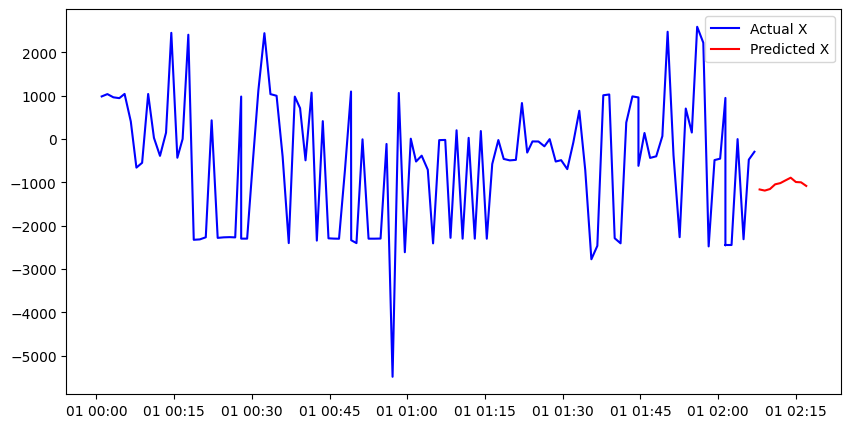

In [17]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, LSTM, Flatten
)
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt


df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create time-series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Look at last 10 time steps
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# Transformer Encoder Block
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    attention = MultiHeadAttention(num_heads=num_heads, key_dim=ff_dim)(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)
    ff_output = Dense(ff_dim, activation="relu")(attention)
    ff_output = Dense(inputs.shape[-1])(ff_output)
    ff_output = Dropout(dropout_rate)(ff_output)
    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# LSTM Decoder Block
def lstm_decoder(inputs, encoder_outputs, lstm_units=64, dropout_rate=0.1):
    lstm_out = LSTM(lstm_units, return_sequences=True)(inputs)
    lstm_out = LSTM(lstm_units, return_sequences=False)(lstm_out)
    lstm_out = Dropout(dropout_rate)(lstm_out)
    return Dense(inputs.shape[-1])(lstm_out)

# Build Transformer-LSTM Model
def build_model(input_shape, num_heads=4, ff_dim=64, lstm_units=64):
    encoder_inputs = Input(shape=input_shape, name="encoder_inputs")
    encoder_outputs = transformer_encoder(encoder_inputs, num_heads, ff_dim)
    encoder_outputs = transformer_encoder(encoder_outputs, num_heads, ff_dim)

    decoder_inputs = Input(shape=input_shape, name="decoder_inputs")
    decoder_outputs = lstm_decoder(decoder_inputs, encoder_outputs, lstm_units)

    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
    return model

# Build and Compile Model
model = build_model((seq_length, X.shape[2]), num_heads=4, ff_dim=64, lstm_units=64)
model.compile(optimizer=Adam(learning_rate=0.001), loss="mse", metrics=['accuracy'])

# Train Model
history = model.fit([X_train, X_train], y_train, epochs=50, batch_size=16, validation_data=([X_test, X_test], y_test))

# Predict next 10 steps
future_steps = 10
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict([input_seq, input_seq])
    future_predictions.append(pred[0])
    input_seq = np.roll(input_seq, -1, axis=1)
    input_seq[0, -1, :] = pred

future_predictions = scaler.inverse_transform(future_predictions)
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()


# with positional encoding

In [21]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, MultiHeadAttention, LayerNormalization, Dropout, LSTM, Flatten, Embedding, Add
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Convert duration to timestamps
df["timestamp"] = pd.to_datetime(df["duration_seconds"].cumsum(), unit="s")
df.set_index("timestamp", inplace=True)

# Normalize features
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

# Function to create time-series sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 10  # Look at last 10 time steps
X, y = create_sequences(scaled_data, seq_length)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, y_train = X[:train_size], y[:train_size]
X_test, y_test = X[train_size:], y[train_size:]

# ... [Previous data preparation code remains the same] ...

# Positional Encoding with Batch Dimension
def positional_encoding(seq_length, d_model):
    """ Generate absolute positional encoding """
    pos = np.arange(seq_length)[:, np.newaxis]  # Shape: (seq_length, 1)
    i = np.arange(d_model)[np.newaxis, :]  # Shape: (1, d_model)

    # Compute the angles for sine and cosine functions
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    pe = pos * angle_rates  # Shape: (seq_length, d_model)

    # Apply sine to even indices and cosine to odd indices
    pe[:, 0::2] = np.sin(pe[:, 0::2])
    pe[:, 1::2] = np.cos(pe[:, 1::2])

    return tf.convert_to_tensor(pe, dtype=tf.float32)


# Define Transformer Encoder Block with Fixed Broadcasting
def transformer_encoder(inputs, num_heads=4, ff_dim=64, dropout_rate=0.1):
    # Get sequence length and feature dimension from input shape
    seq_length = inputs.shape[1]
    d_model = inputs.shape[2]

    # Generate and reshape positional encoding
    pos_encoding = positional_encoding(seq_length, d_model)
    pos_encoding = tf.expand_dims(pos_encoding, axis=0)  # Add batch dimension [1, seq_length, d_model]

    # Add positional encoding to inputs
    inputs = Add()([inputs, pos_encoding])

    # Multi-Head Attention with compatible dimensions
    attention = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=d_model//num_heads  # Ensure key_dim divides evenly into feature dimension
    )(inputs, inputs)
    attention = Dropout(dropout_rate)(attention)
    attention = LayerNormalization(epsilon=1e-6)(inputs + attention)  # Residual connection

    # Feed-Forward Network
    ff_output = Dense(ff_dim, activation=tf.keras.activations.relu)(attention)
    ff_output = Dense(d_model)(ff_output)  # Maintain original feature dimension
    ff_output = Dropout(dropout_rate)(ff_output)

    return LayerNormalization(epsilon=1e-6)(attention + ff_output)

# Define LSTM Decoder
def lstm_decoder(inputs, units=64):
    x = LSTM(units, return_sequences=True)(inputs)
    x = LSTM(units)(x)  # Removed return_sequences=False as it's default
    return x

# Build the Model with Compatible Dimensions
def build_transformer_lstm_model(input_shape, num_heads=4, ff_dim=64, lstm_units=64):
    inputs = Input(shape=input_shape)

    # Transformer Encoder
    x = transformer_encoder(inputs, num_heads=num_heads, ff_dim=ff_dim)
    x = transformer_encoder(x, num_heads=num_heads, ff_dim=ff_dim)

    # LSTM Decoder
    x = lstm_decoder(x, units=lstm_units)

    # Final Output
    outputs = Dense(input_shape[1])(x)  # Predict all features
    model = Model(inputs, outputs)
    return model

# Build and Compile Model with Appropriate Parameters
model = build_transformer_lstm_model(
    input_shape=(seq_length, X.shape[2]),
    num_heads=2,  # Changed to ensure d_model % num_heads == 0
    ff_dim=32,
    lstm_units=32
)

# Compile with correct learning rate syntax
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="mse",
    metrics=['accuracy']  # Better for regression than accuracy
)

# Train the Model
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=16,
    validation_data=(X_test, y_test),
    verbose=1
)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 8s 197ms/step - accuracy: 0.4727 - loss: 0.3147 - val_accuracy: 0.6818 - val_loss: 0.1930
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6499 - loss: 0.1749 - val_accuracy: 0.6818 - val_loss: 0.0992
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6579 - loss: 0.0907 - val_accuracy: 0.6818 - val_loss: 0.0779
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6529 - loss: 0.0665 - val_accuracy: 0.6818 - val_loss: 0.0715
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7482 - loss: 0.0588 - val_accuracy: 0.6818 - val_loss: 0.0692
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5907 - loss: 0.0593 - val_accuracy: 0.6818 - val_loss: 0.0703
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.6651 - loss: 0.0500 - val_accuracy: 0.6818 - val_loss: 0.0726
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.6160 - loss: 0.0593 - val_accuracy: 0.6818 - val_loss: 0.0699

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 438ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


<ipython-input-23-db37e806a4df>:18: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]


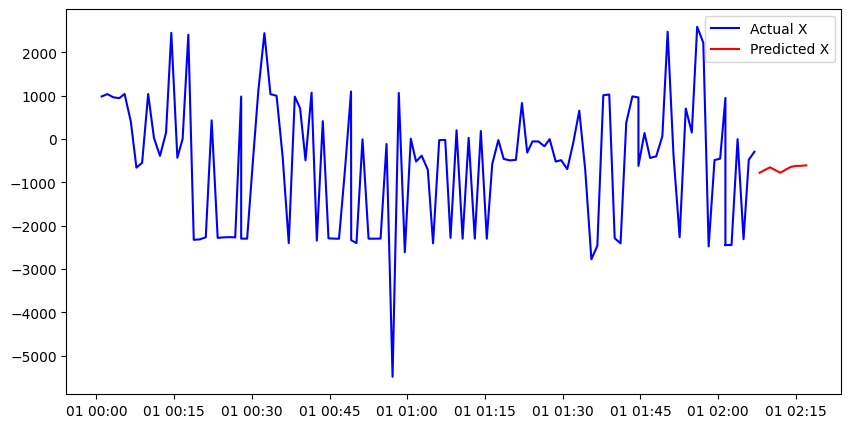

In [23]:
# Predict next 10 steps
future_steps = 10
future_predictions = []
input_seq = X_test[-1].reshape(1, seq_length, X.shape[2])

for _ in range(future_steps):
    pred = model.predict(input_seq)  # Only one input
    future_predictions.append(pred[0])  # Extract prediction

    # Shift input sequence and insert new prediction
    input_seq = np.roll(input_seq, -1, axis=1)
    input_seq[0, -1, :] = pred  # Insert prediction into last time step

# Convert back to original scale
future_predictions = scaler.inverse_transform(future_predictions)

# Create a DataFrame for predicted values
future_timestamps = pd.date_range(df.index[-1], periods=future_steps+1, freq="1T")[1:]
forecast_df = pd.DataFrame(future_predictions, columns=df.columns, index=future_timestamps)

# Plot Predictions
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["x"], label="Actual X", color="blue")
plt.plot(forecast_df.index, forecast_df["x"], label="Predicted X", color="red")
plt.legend()
plt.show()
